<a href="https://colab.research.google.com/github/markaljm/Diabetes-130-US-hospitals-for-years-1999-2008-Data-Set/blob/main/Diabetes_Readmission_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [186]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# **Import Data**

In [187]:
data = pd.read_csv("./diabetic_data.csv")

In [188]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
data.shape

(101766, 50)

In [190]:
data.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

# **Data  Cleaning**

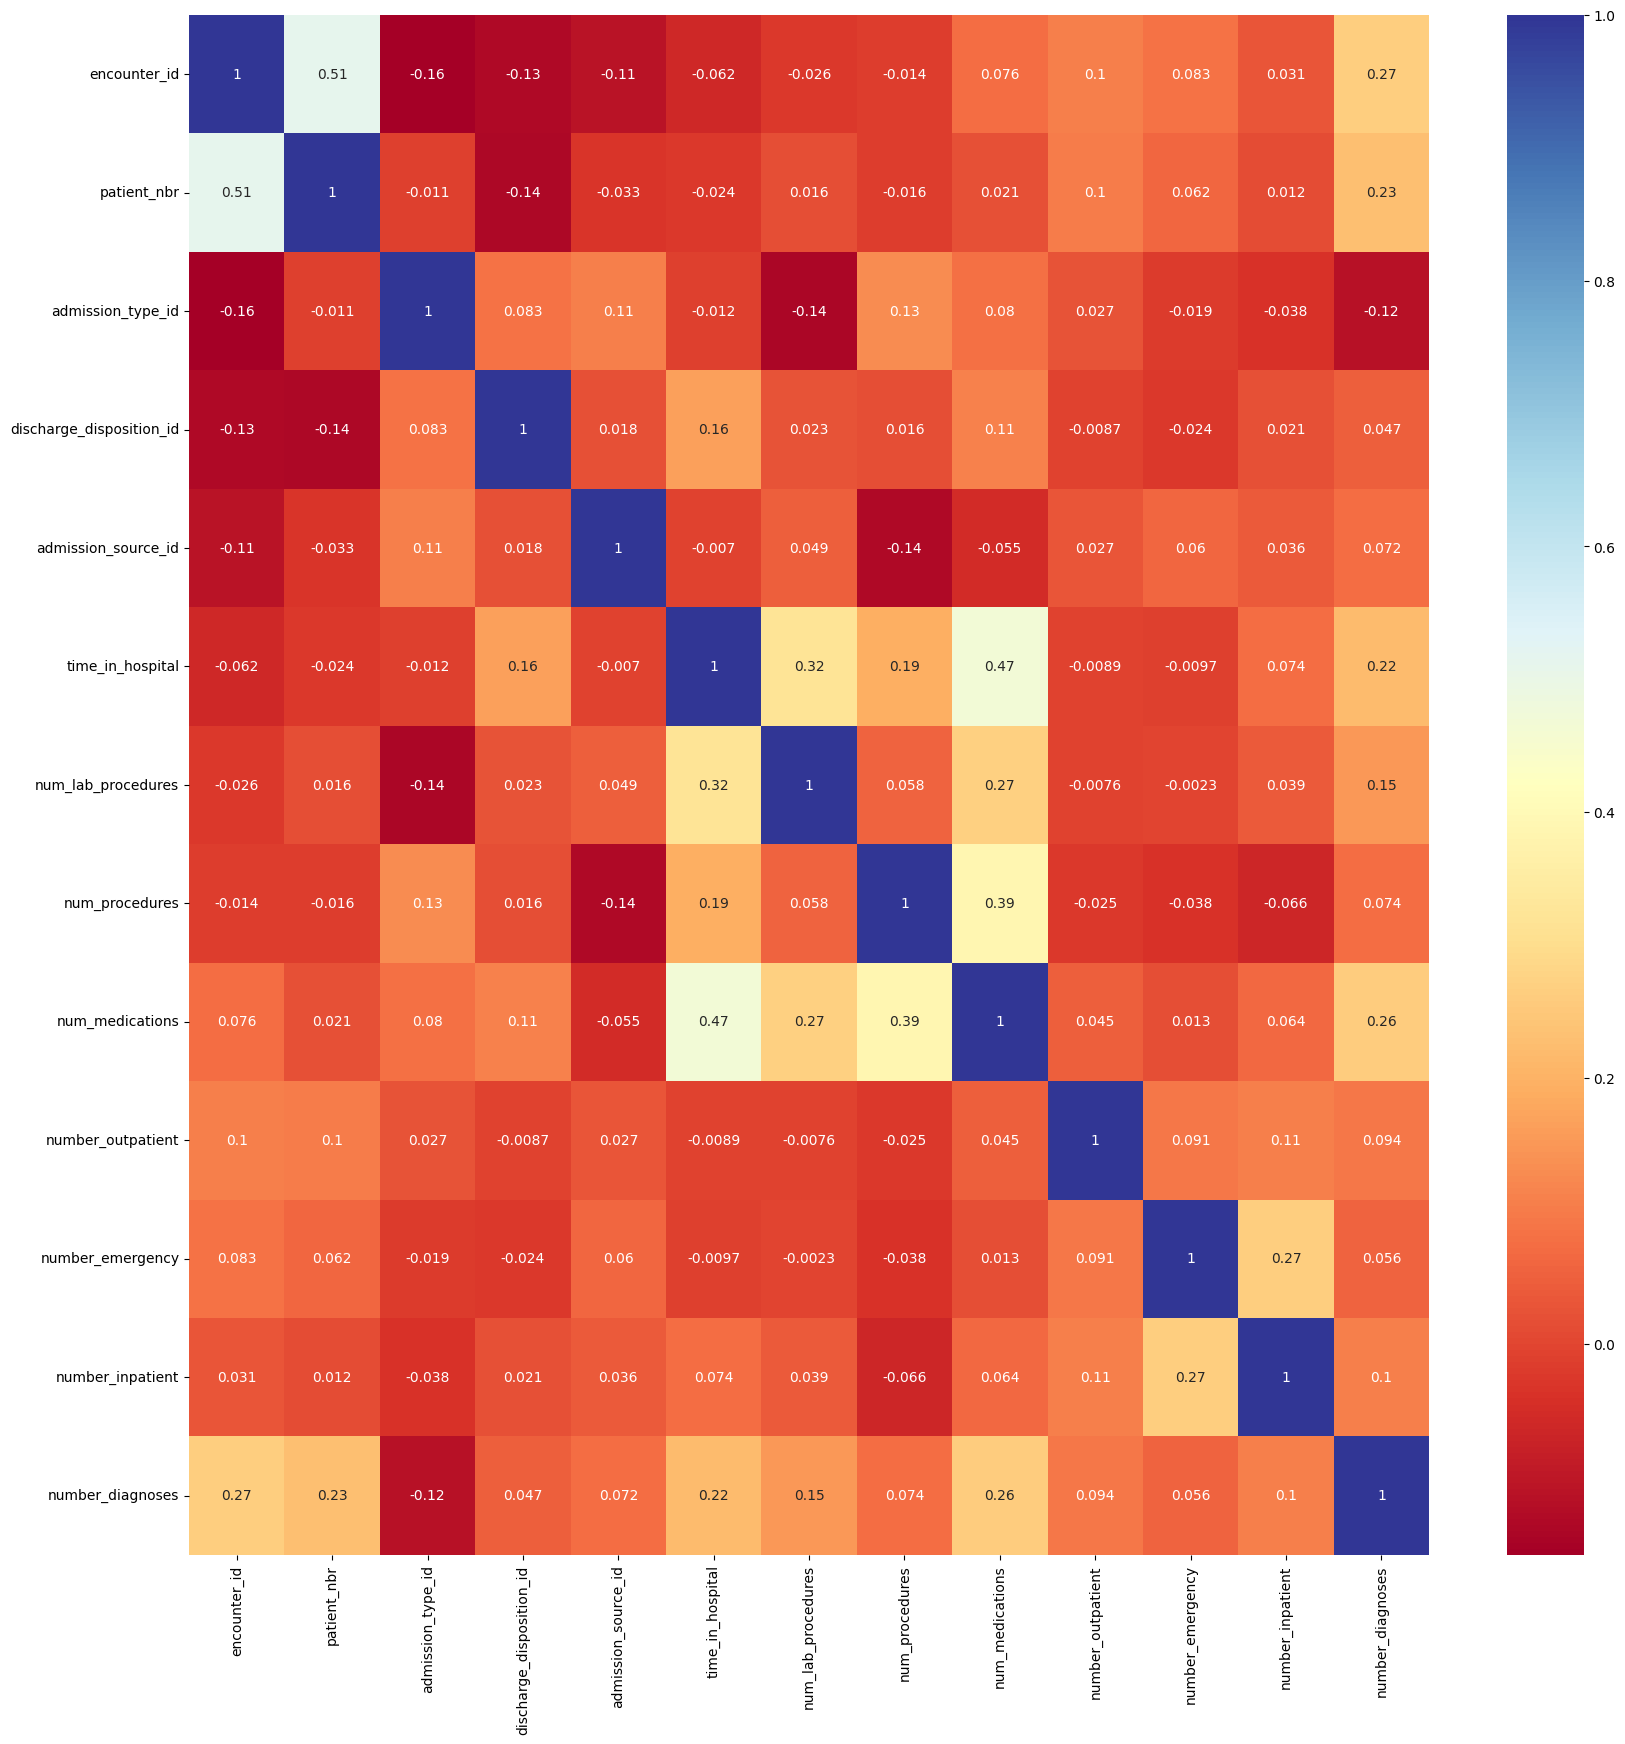

In [191]:
## Correlation

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlBu")

In [192]:
for i in data.columns:
    print(i, data[data[i] == '?'].shape[0])

encounter_id 0
patient_nbr 0
race 2273
gender 0
age 0
weight 98569
admission_type_id 0
discharge_disposition_id 0
admission_source_id 0
time_in_hospital 0
payer_code 40256
medical_specialty 49949
num_lab_procedures 0
num_procedures 0
num_medications 0
number_outpatient 0
number_emergency 0
number_inpatient 0
diag_1 21
diag_2 358
diag_3 1423
number_diagnoses 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


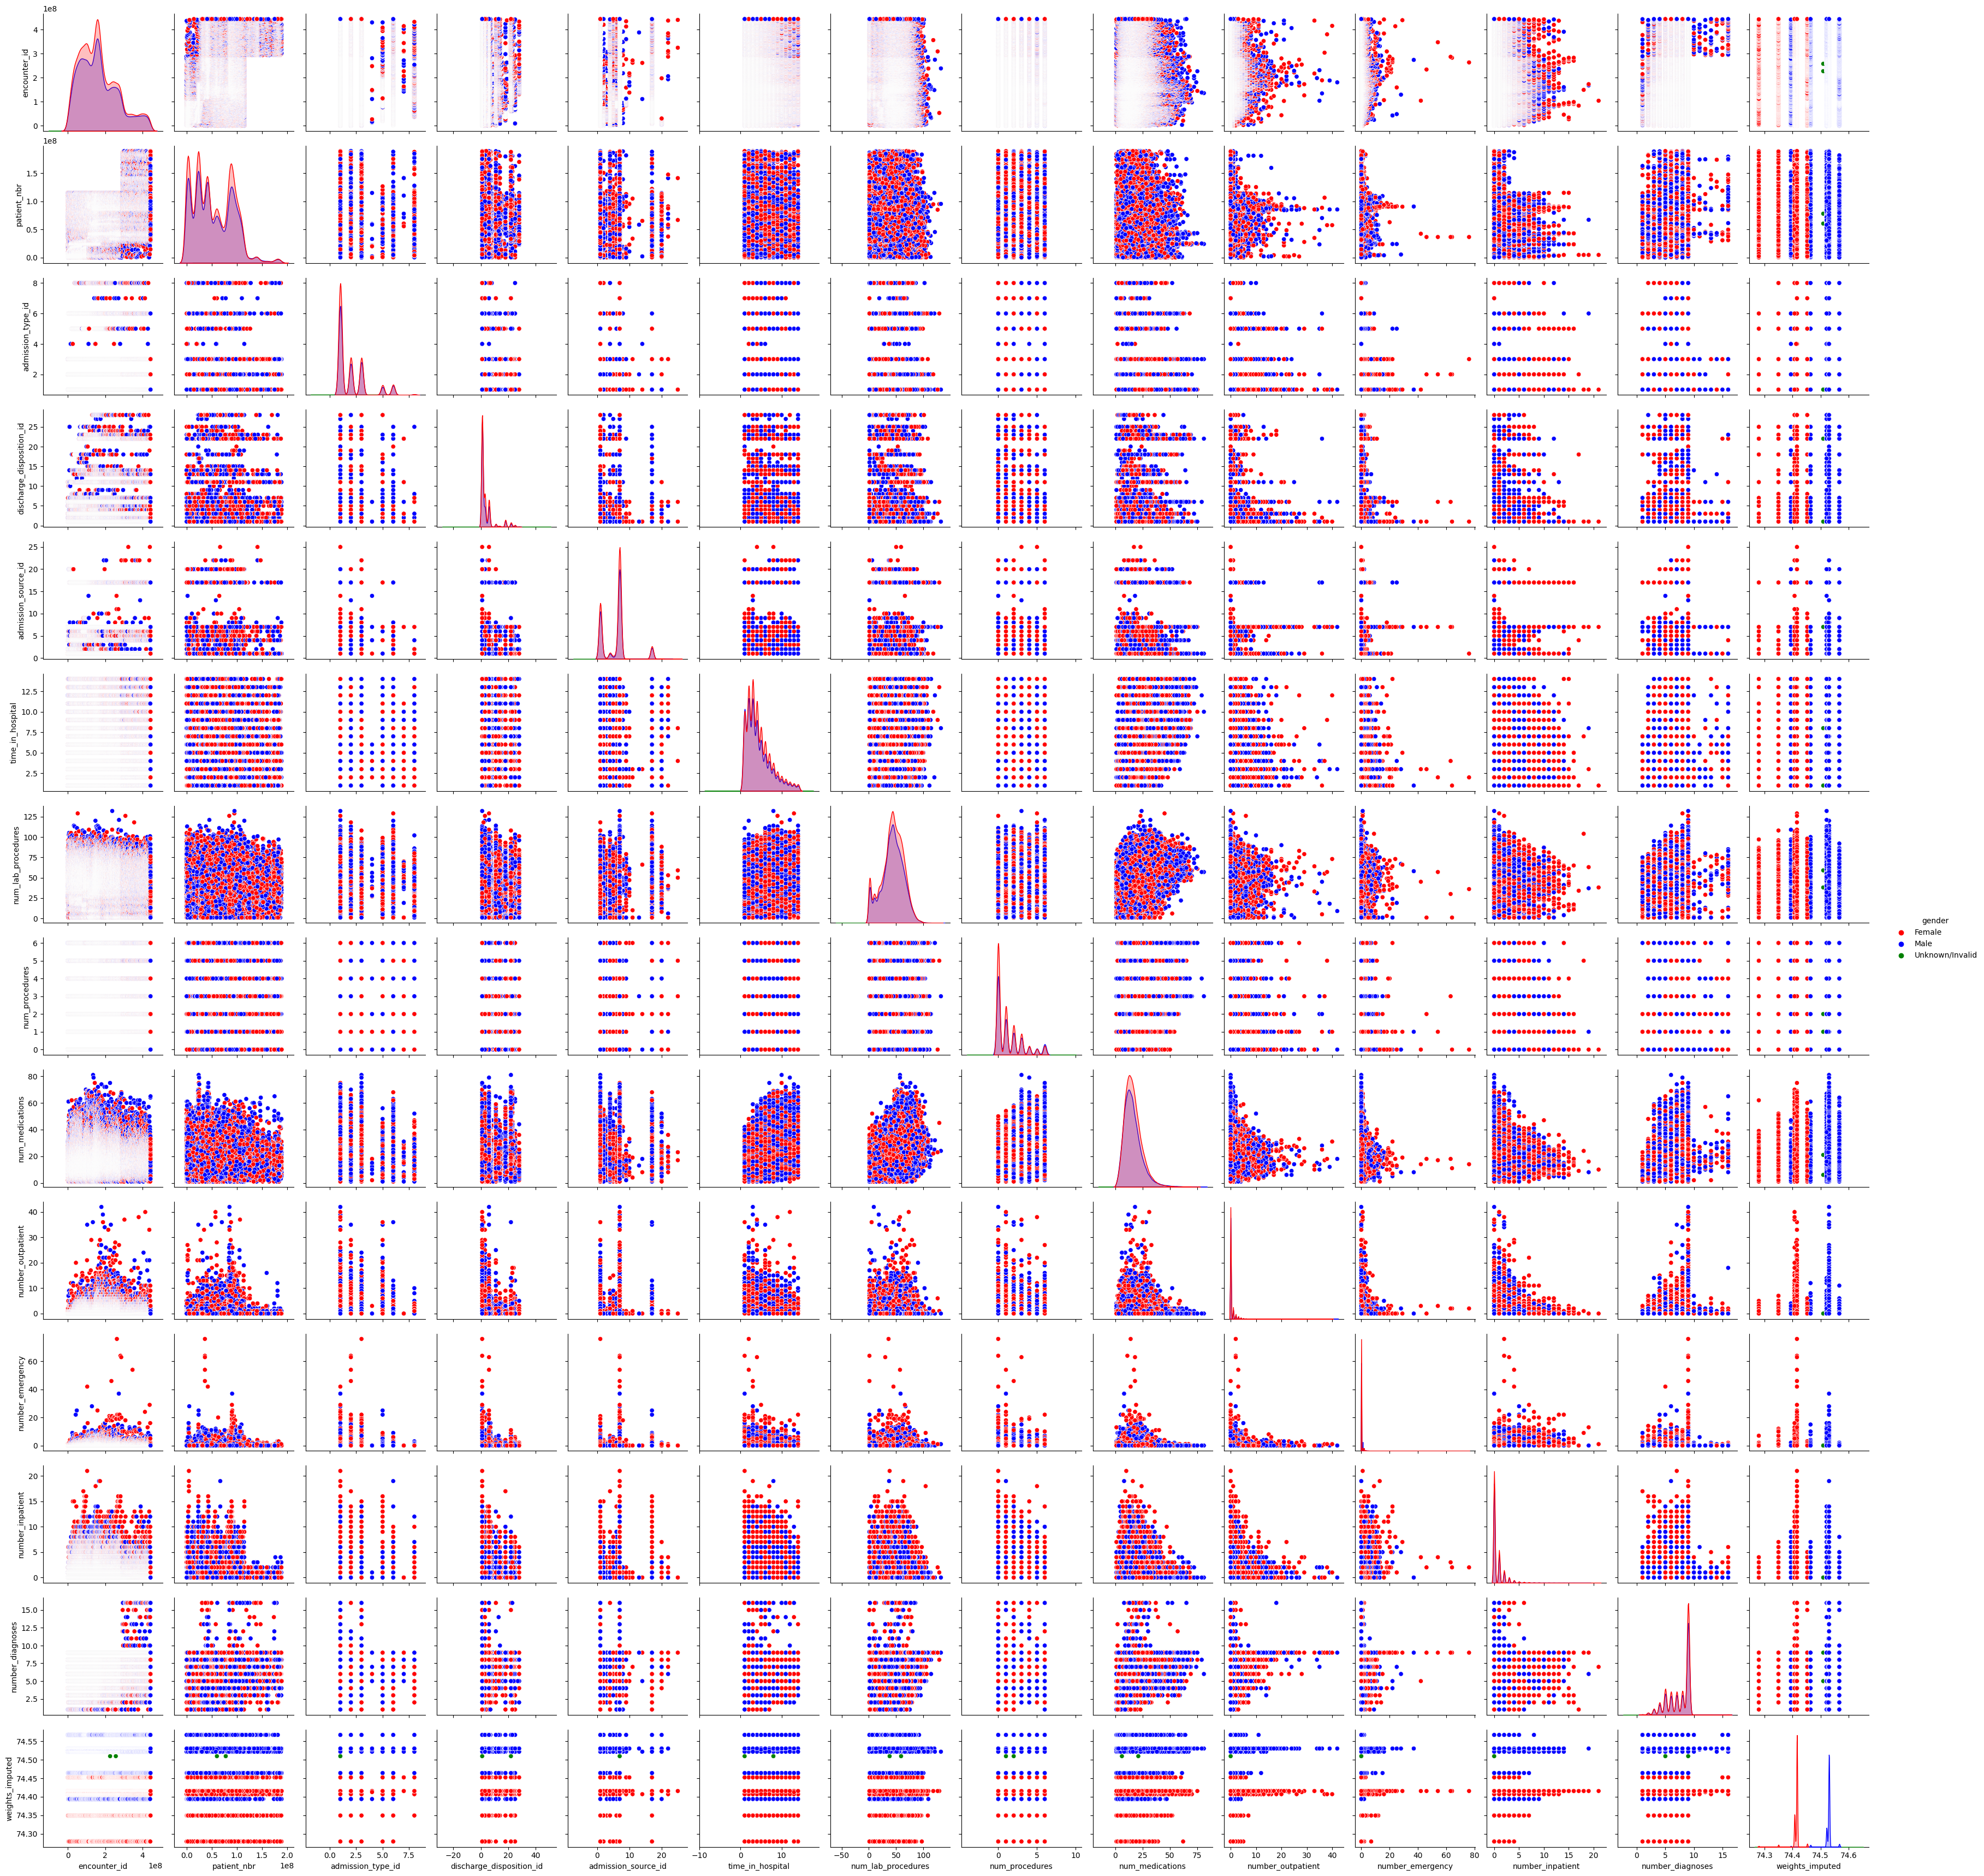

In [252]:
# Change based on gender
sns.pairplot(data, hue='gender', palette={'Female': 'red', 'Male': 'blue', 'Unknown/Invalid': 'green'})

In [193]:
data['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

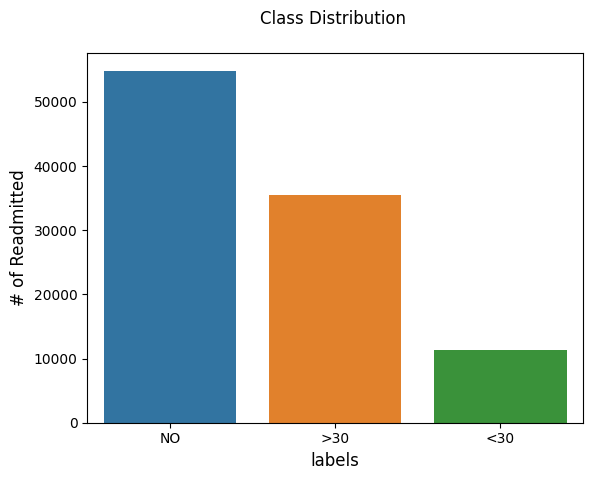

In [194]:
ax = sns.barplot(x=data['readmitted'].value_counts().index,   y=data['readmitted'].value_counts())
plt.xlabel('labels', size = 12)
plt.ylabel('# of Readmitted', size = 12)
plt.title('Class Distribution \n', size = 12)
plt.show()

In [195]:
#Created Another label to map <30 and >30 to 1 class for better Analysis and Classification.
data['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [196]:
# Created another column and take it as 2 class problem, Label the <30 and >30 as YES and Other "N0" as No.

def check_label(text):
    if text == '>30' or text =='<30':
        return 'Yes'
    else:
        return 'No'
    
data['readmitted_2'] =data['readmitted'].apply(check_label) 

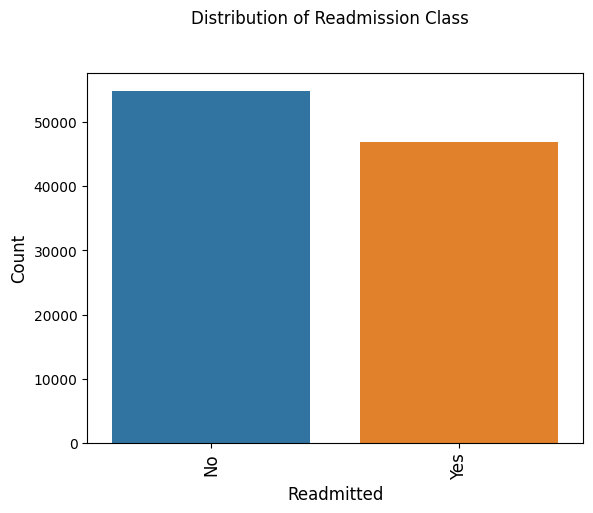

In [197]:
ax = sns.countplot(x='readmitted_2',   data= data)
plt.xlabel('Readmitted', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Readmission Class  \n\n', size = 12)
plt.show()

In [198]:
data.loc[data['race'] == '?', 'race'] = 'Other'

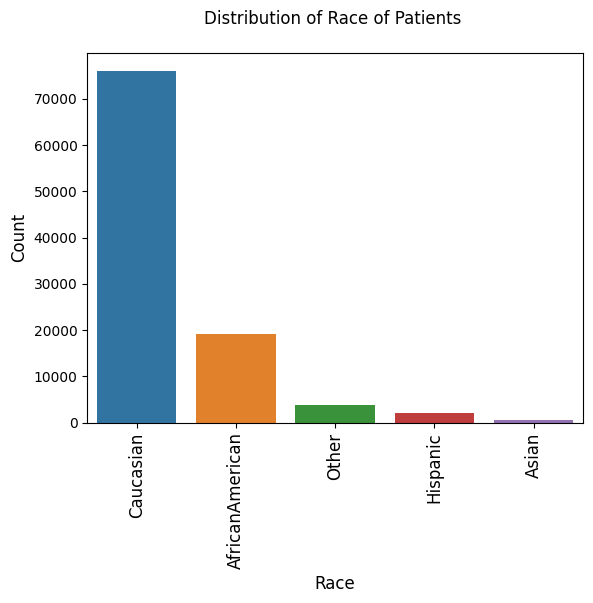

In [199]:
ax = sns.barplot(x=data['race'].value_counts().index,   y=data['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

In [200]:
data['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [201]:
# Drop the "Unknown/Invalid" gender of the data.
data.drop(data[data['gender'] == 'Unknown/Invalid'].index, inplace = True)

In [202]:
data.reset_index(inplace = True, drop = True)

In [203]:
data['gender'].value_counts()

Female    54708
Male      47055
Name: gender, dtype: int64

In [204]:
data.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... insulin glyburide-metformin  glipizide-metformin  \
0                 1  ...      No                  No                   No   
1                 3  ...      Up                  No                   No   
2                 2  ...      No                  No                   No   
3                 2  ...      Up                  No                   No   
4                 1  ...  Steady                  No                   No   

   glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  \
0                        No                       No                      No   
1                        No                       No                      No   
2                        No                       No                      No   
3                        No                       No                      No   
4                        No                       No                      No   

   change  diabetesMed readmitted readmitted_2  
0      No           No         NO           No  
1      Ch          Yes        >30          Yes  
2      No          Yes         NO           No  
3      Ch          Yes         NO           No  
4      Ch          Yes         NO           No  

[5 rows x 51 columns]

# **Imputed Weight**

In [205]:
data = pd.read_csv("./diabetic_data.csv", na_values="?")

<ipython-input-205-60109bb2f395>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./diabetic_data.csv", na_values="?")


In [206]:
# Split the data into independent and dependent variables
X = data[["race", "gender"]]
y = data["weight"]

In [207]:
# Create a mapping of the non-numeric values to numerical values
weights_map = {"[0-25)": 10, "[25-50)": 37.5, "[50-75)": 62.5, "[75-100)": 87.5}

In [208]:
# Replace the non-numeric values with their corresponding numerical values
y = y.map(weights_map)

In [209]:
# Impute missing values in the dependent variable using the mean of the column
imputer = SimpleImputer(strategy="mean")
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1))

In [210]:
# Apply one-hot encoding to the independent variables
ct = ColumnTransformer(
    transformers=[
        ("encoder", OneHotEncoder(), ["race", "gender"])
    ],
    remainder="passthrough"
)
X_encoded = ct.fit_transform(X)

In [211]:
# Train a linear regression model to predict the weights based on race and gender
regressor = LinearRegression()
regressor.fit(X_encoded, y_imputed)

LinearRegression()

In [212]:
# Use the trained model to impute the missing weights
weights_imputed = regressor.predict(X_encoded)

In [213]:
# Add the imputed weights back to the DataFrame
data["weights_imputed"] = weights_imputed.flatten()

In [214]:
# Add a new column to the DataFrame to record the imputation method
data["imputation_method"] = "Weight Imputation - Linear Regression with One-Hot Encoding"


In [215]:
# Save the imputed data to a new CSV file
data.to_csv("imputed_data.csv", index=False)

In [216]:
# Print a message to confirm that the imputation was successful
print("Weight imputation successful. Imputed data saved to imputed_data.csv.")

Weight imputation successful. Imputed data saved to imputed_data.csv.


In [217]:
df = pd.read_csv("./imputed_data.csv")

<ipython-input-217-d076a1a8acb7>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./imputed_data.csv")


In [218]:
df.shape

(101766, 52)

In [219]:
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

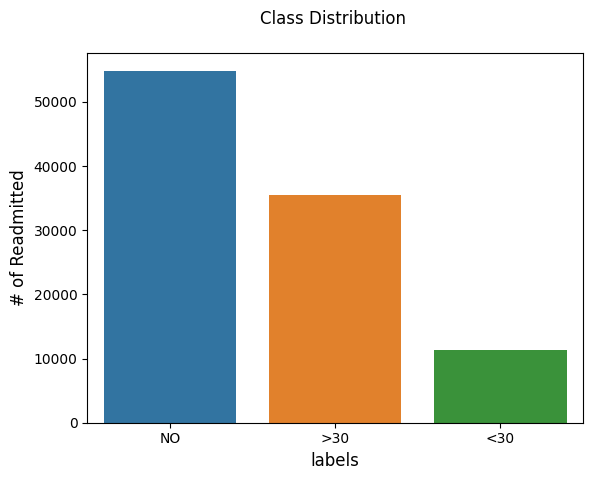

In [220]:
ax = sns.barplot(x=df['readmitted'].value_counts().index,   y=df['readmitted'].value_counts())
plt.xlabel('labels', size = 12)
plt.ylabel('# of Readmitted', size = 12)
plt.title('Class Distribution \n', size = 12)
plt.show()

In [221]:
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [222]:
# Created another column and take it as 2 class problem, Label the <30 and >30 as YES and Other "N0" as No.

def check_label(text):
    if text == '>30' or text =='<30':
        return 'Yes'
    else:
        return 'No'
    
df['readmitted_2'] =df['readmitted'].apply(check_label) 

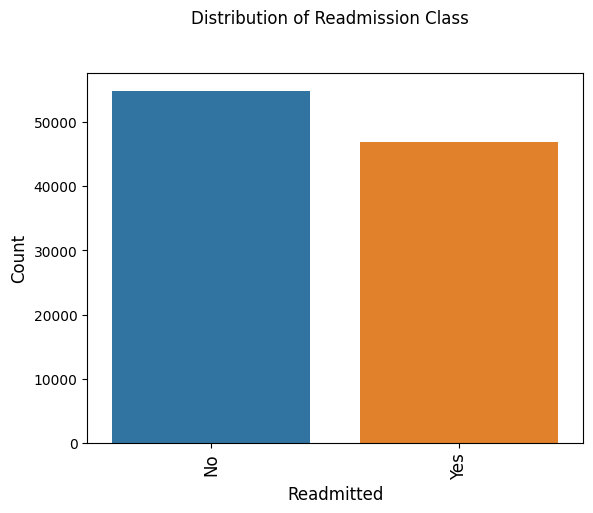

In [223]:
ax = sns.countplot(x='readmitted_2',   data= df)
plt.xlabel('Readmitted', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Readmission Class  \n\n', size = 12)
plt.show()

In [224]:
# Lets drop this column. 
df.drop(columns = ['weight'], inplace = True)

In [225]:
df['payer_code'].value_counts()

MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64

In [226]:
df.drop(columns =['medical_specialty'], inplace = True)

In [227]:
df.drop(columns = ['acetohexamide','imputation_method', 'payer_code','tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

In [228]:
df.shape

(101766, 39)

In [229]:
df = df[~((df['diag_1'] == "?") | (df['diag_2'] == "?") | (df['diag_3'] == "?"))]

In [230]:
df.shape

(101766, 39)

# **Transform Categorical Features**

In [231]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

In [232]:
categorical_features =['race', "weights_imputed",'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed'] 

for i in categorical_features:
    df[i] = le.fit_transform(df[i])

In [233]:
df.head()

encounter_id  patient_nbr  race  gender  age  admission_type_id  \
0       2278392      8222157     2       0    0                  5   
1        149190     55629189     2       0    1                  0   
2         64410     86047875     0       0    2                  0   
3        500364     82442376     2       1    3                  0   
4         16680     42519267     2       1    4                  0   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        23                    0                 1   
1                         0                    6                 3   
2                         0                    6                 2   
3                         0                    6                 2   
4                         0                    6                 1   

   num_lab_procedures  ...  rosiglitazone  acarbose  miglitol  insulin  \
0                  41  ...              1         1         1        1   
1                  59  ...              1         1         1        3   
2                  11  ...              1         1         1        1   
3                  44  ...              1         1         1        3   
4                  51  ...              1         1         1        2   

   glyburide-metformin  change  diabetesMed  readmitted  weights_imputed  \
0                    1       1            0          NO                6   
1                    1       0            1         >30                6   
2                    1       1            1          NO                4   
3                    1       0            1          NO               12   
4                    1       0            1          NO               12   

   readmitted_2  
0            No  
1           Yes  
2            No  
3            No  
4            No  

[5 rows x 39 columns]

# **Split Train Test Data**

In [234]:
label = le.fit(df['readmitted_2'])

In [235]:
df['readmitted_2_encoded'] = label.transform(df['readmitted_2'])  #After Label Encoding the values assigned to class values are O:No Yes:1

In [236]:
df= df.drop(columns= ['encounter_id', 'patient_nbr', 'readmitted','readmitted_2']) #Feature correaltion to drop

In [237]:
df

race  gender  age  admission_type_id  discharge_disposition_id  \
0          2       0    0                  5                        23   
1          2       0    1                  0                         0   
2          0       0    2                  0                         0   
3          2       1    3                  0                         0   
4          2       1    4                  0                         0   
...      ...     ...  ...                ...                       ...   
101761     0       1    7                  0                         2   
101762     0       0    8                  0                         3   
101763     2       1    7                  0                         0   
101764     2       0    8                  1                         2   
101765     2       1    7                  0                         0   

        admission_source_id  time_in_hospital  num_lab_procedures  \
0                         0                 1                  41   
1                         6                 3                  59   
2                         6                 2                  11   
3                         6                 2                  44   
4                         6                 1                  51   
...                     ...               ...                 ...   
101761                    6                 3                  51   
101762                    4                 5                  33   
101763                    6                 1                  53   
101764                    6                10                  45   
101765                    6                 6                  13   

        num_procedures  num_medications  ...  pioglitazone  rosiglitazone  \
0                    0                1  ...             1              1   
1                    0               18  ...             1              1   
2                    5               13  ...             1              1   
3                    1               16  ...             1              1   
4                    0                8  ...             1              1   
...                ...              ...  ...           ...            ...   
101761               0               16  ...             1              1   
101762               3               18  ...             1              1   
101763               0                9  ...             1              1   
101764               2               21  ...             2              1   
101765               3                3  ...             1              1   

        acarbose  miglitol  insulin  glyburide-metformin  change  diabetesMed  \
0              1         1        1                    1       1            0   
1              1         1        3                    1       0            1   
2              1         1        1                    1       1            1   
3              1         1        3                    1       0            1   
4              1         1        2                    1       0            1   
...          ...       ...      ...                  ...     ...          ...   
101761         1         1        0                    1       0            1   
101762         1         1        2                    1       1            1   
101763         1         1        0                    1       0            1   
101764         1         1        3                    1       0            1   
101765         1         1        1                    1       1            0   

        weights_imputed  readmitted_2_encoded  
0                     6                     0  
1                     6                     1  
2                     4                     0  
3                    12                     0  
4                    12                     0  
...                 ...                   ...  
101761               10                     1  
101762  

In [238]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'weights_imputed',
       'readmitted_2_encoded'],
      dtype='object')

In [239]:
#Split dependent and independant parameters 
X = df.drop(columns= ['readmitted_2_encoded'])
Y = df['readmitted_2_encoded']

In [240]:
# Feature scaling
from sklearn import preprocessing
scaled_X = preprocessing.StandardScaler().fit_transform(X)

In [241]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.20, random_state=42)

In [242]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((81412, 35), (20354, 35), (81412,), (20354,))

In [243]:
# Train the random forest classifier model
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [244]:
# Predict the test set results
y_pred = classifier.predict(X_test)

# **Model performance**

In [245]:
# Evaluate the model performance
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[8046 2906]
 [4515 4887]]
0.635403360518817


In [246]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 450, max_depth=9, random_state=43)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=450, random_state=43)

In [247]:
rf_prediction =  rf.predict(X_test)

In [248]:
print(classification_report(y_test, rf_prediction, target_names= ['Not Readmitted', 'Readmitted']))

                precision    recall  f1-score   support

Not Readmitted       0.63      0.77      0.70     10952
    Readmitted       0.64      0.48      0.55      9402

      accuracy                           0.64     20354
     macro avg       0.64      0.63      0.62     20354
  weighted avg       0.64      0.64      0.63     20354

